# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [3]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

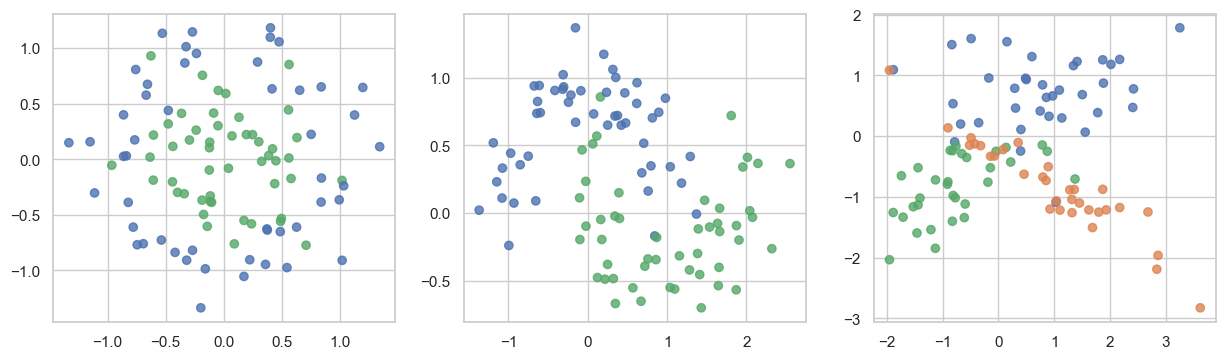

In [4]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [5]:
def plot_surface(clf, X, y):
    plt.figure()
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

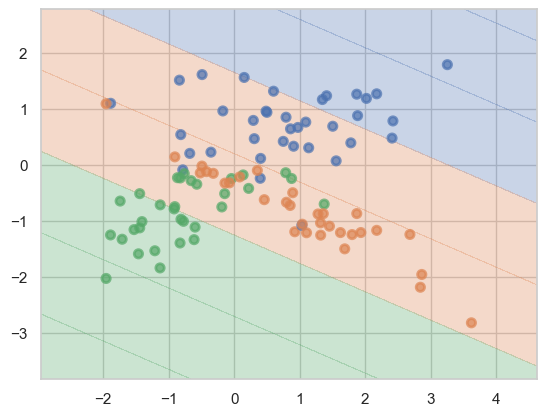

In [6]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

Dataset 1: Train accuracy = 1.0000, Test accuracy = 0.7333
Dataset 2: Train accuracy = 1.0000, Test accuracy = 0.8667
Dataset 3: Train accuracy = 1.0000, Test accuracy = 0.8333


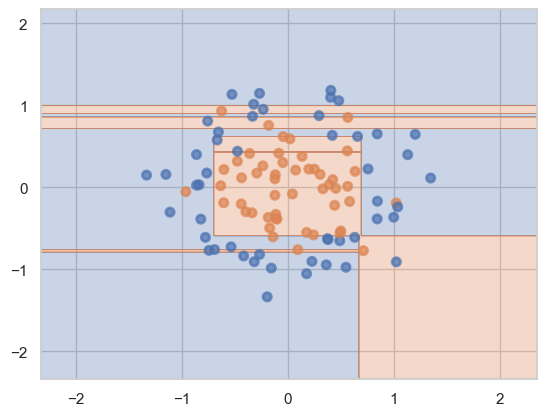

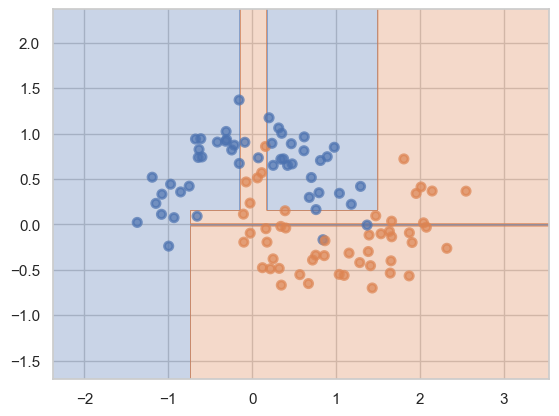

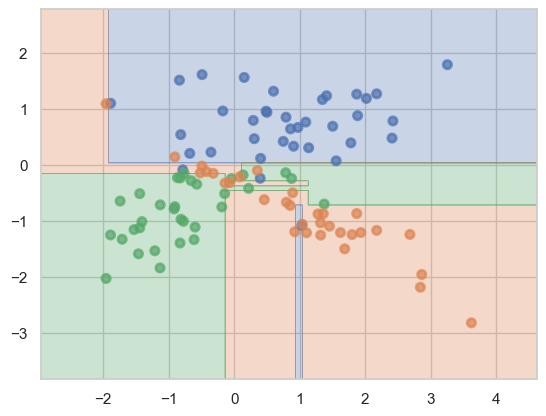

In [7]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    print(f"Dataset {i+1}: Train accuracy = {train_acc:.4f}, Test accuracy = {test_acc:.4f}")

    plot_surface(clf, X, y)

__Ответ:__ Анализ: Для circles: Train ~1.0, Test ~0.73 - переобучение. Moons: Train ~1.0, Test ~0.87 - переобучение. Classification: Train ~1.0, Test ~0.83 - переобучение. Поверхности сложные, захватывают шум на train.

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

Dataset 1, Params {'max_depth': 3, 'min_samples_leaf': 1}: Train = 0.8857, Test = 0.7333
Dataset 1, Params {'max_depth': 5, 'min_samples_leaf': 5}: Train = 0.8714, Test = 0.9000
Dataset 1, Params {'max_depth': None, 'min_samples_leaf': 10}: Train = 0.8143, Test = 0.7667
Dataset 2, Params {'max_depth': 3, 'min_samples_leaf': 1}: Train = 0.9143, Test = 0.9333
Dataset 2, Params {'max_depth': 5, 'min_samples_leaf': 5}: Train = 0.9571, Test = 0.7333
Dataset 2, Params {'max_depth': None, 'min_samples_leaf': 10}: Train = 0.8714, Test = 0.7667
Dataset 3, Params {'max_depth': 3, 'min_samples_leaf': 1}: Train = 0.9429, Test = 0.8667
Dataset 3, Params {'max_depth': 5, 'min_samples_leaf': 5}: Train = 0.9000, Test = 0.7000
Dataset 3, Params {'max_depth': None, 'min_samples_leaf': 10}: Train = 0.8857, Test = 0.7667


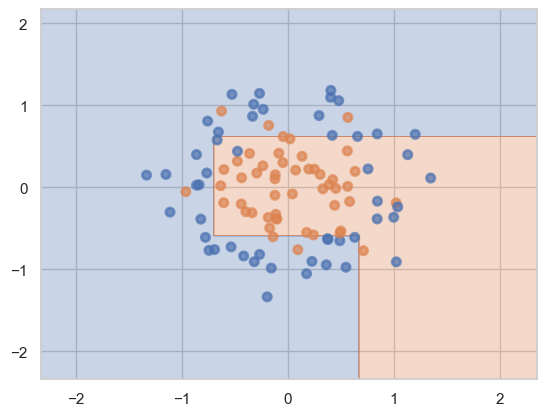

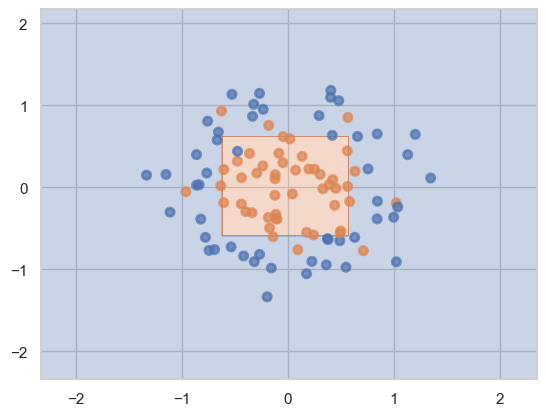

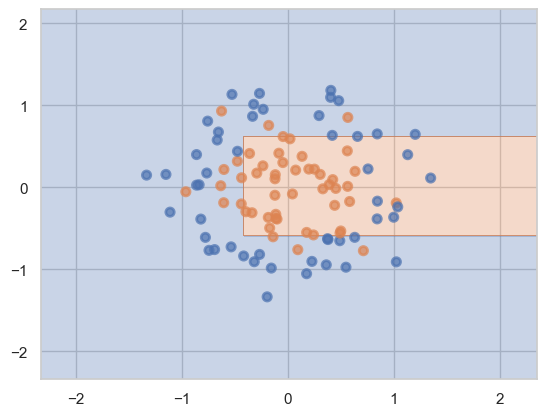

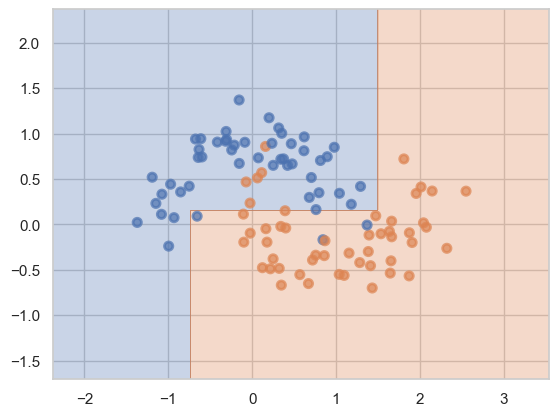

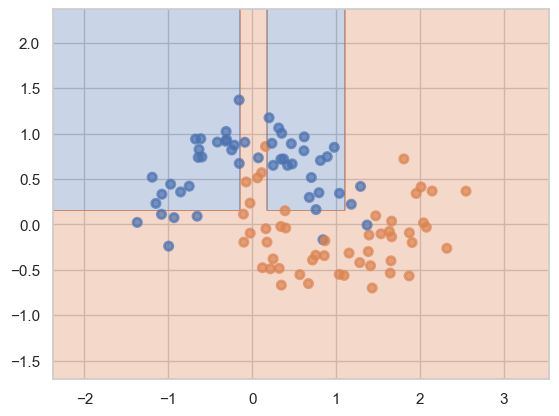

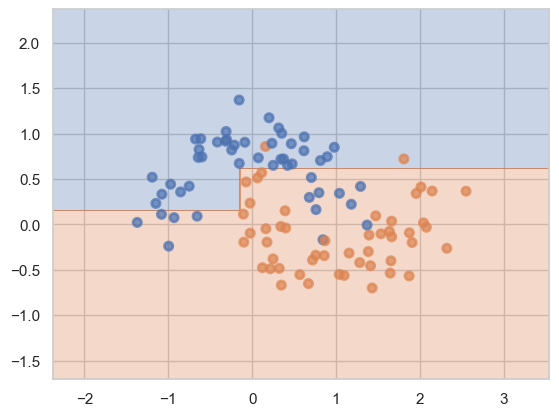

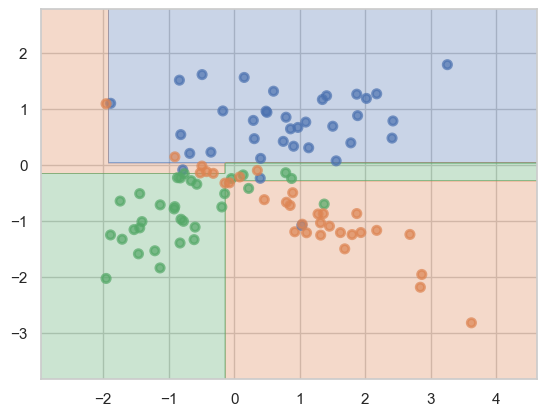

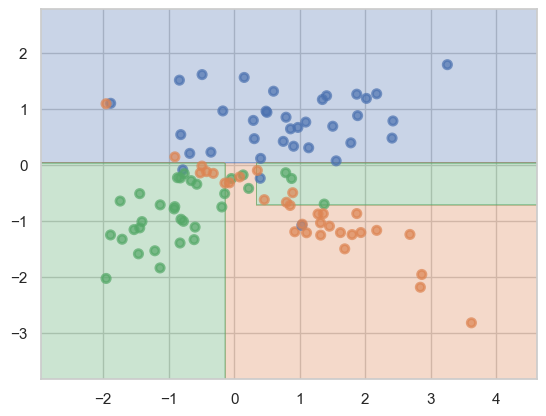

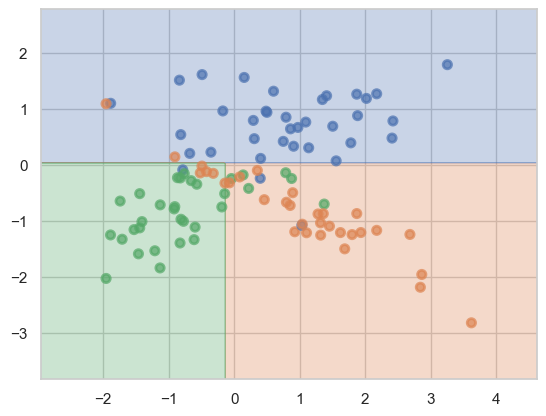

In [8]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

params = [
    {'max_depth': 3, 'min_samples_leaf': 1},
    {'max_depth': 5, 'min_samples_leaf': 5},
    {'max_depth': None, 'min_samples_leaf': 10}
]

for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    for param in params:
        clf = DecisionTreeClassifier(**param, random_state=42)
        clf.fit(X_train, y_train)

        train_acc = clf.score(X_train, y_train)
        test_acc = clf.score(X_test, y_test)
        print(f"Dataset {i+1}, Params {param}: Train = {train_acc:.4f}, Test = {test_acc:.4f}")

        plot_surface(clf, X, y)

__Ответ:__С ростом max_depth качество на test сначала растет, затем падает (переобучение). min_samples_leaf сглаживает поверхность, улучшает обобщение. Для circles/moans (нелинейные) регуляризация критична; для classification изменения меньше, так как данные проще.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

**Реализовала**

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

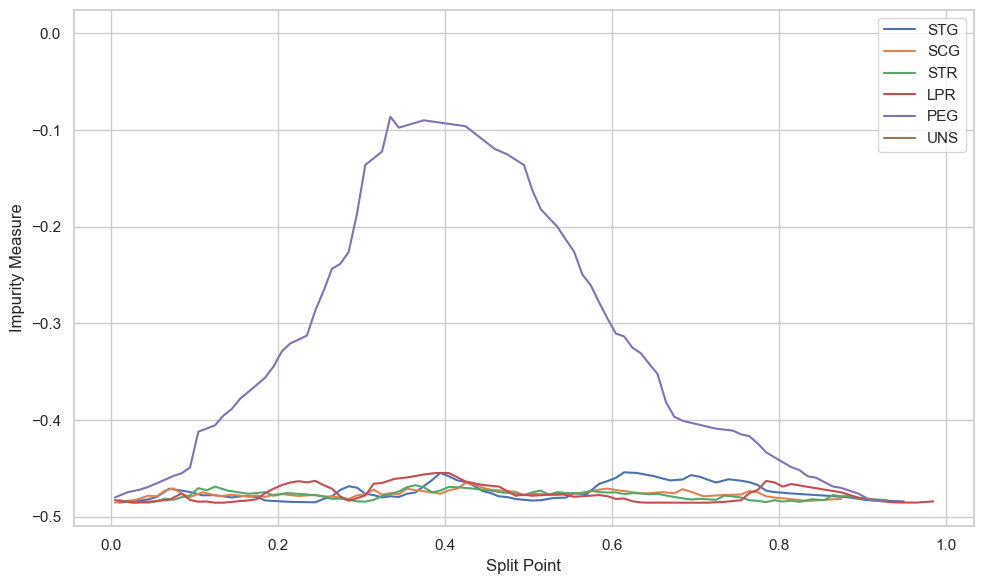

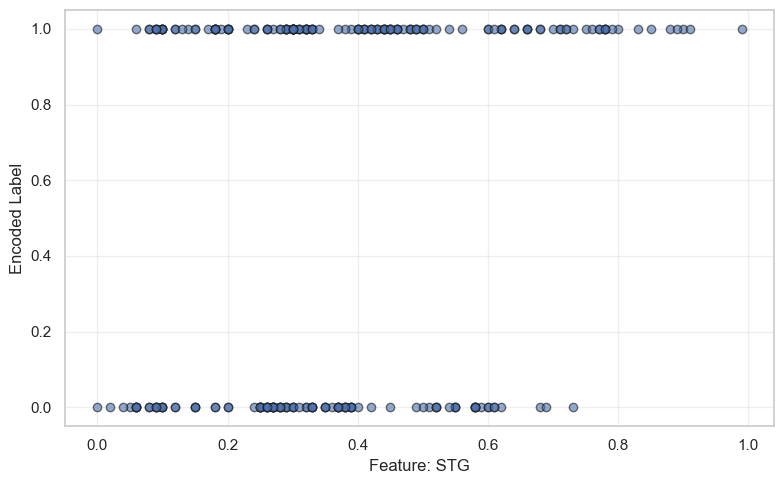

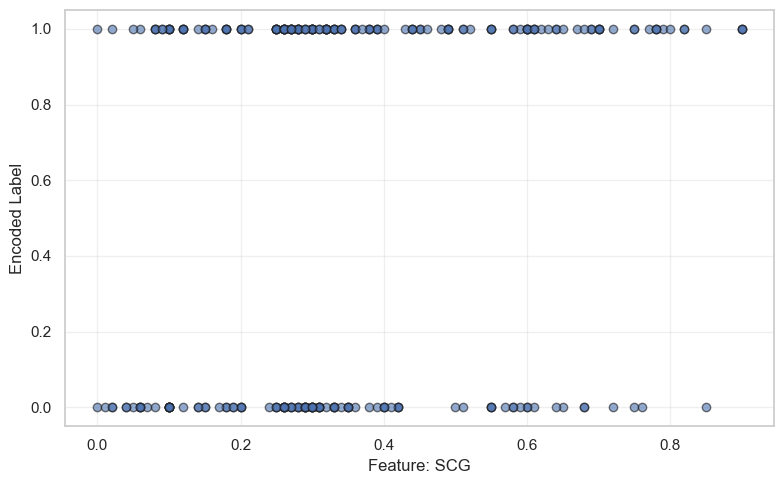

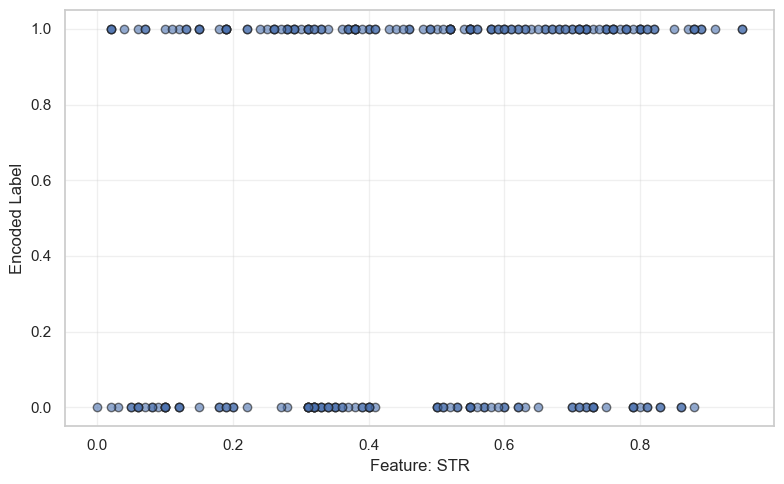

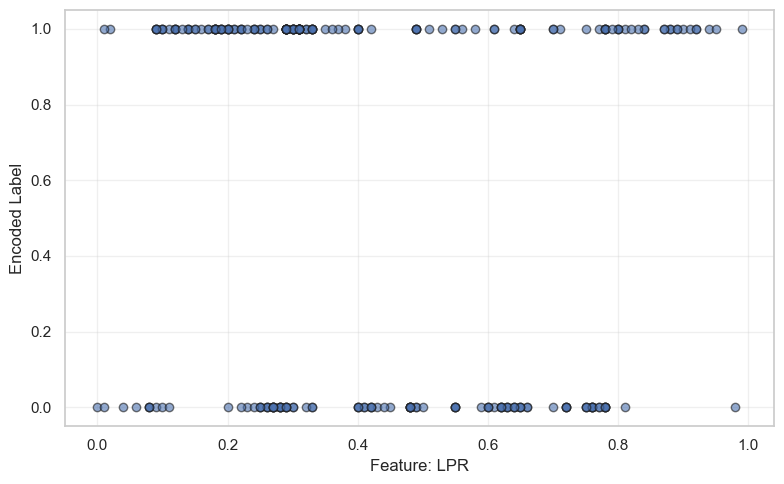

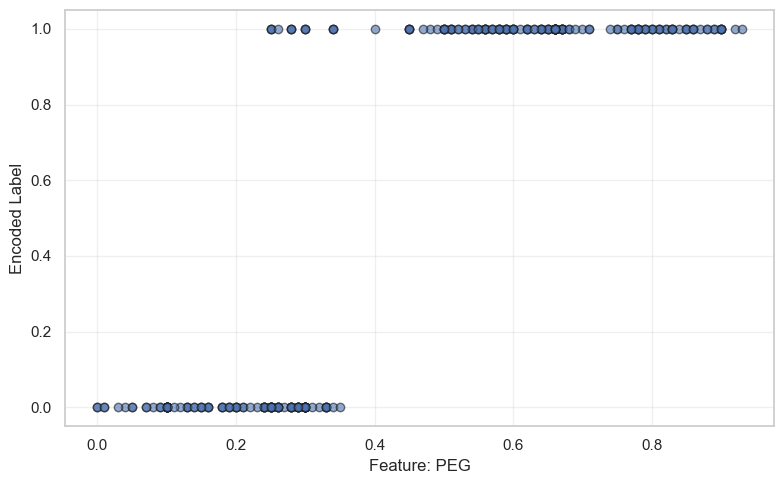

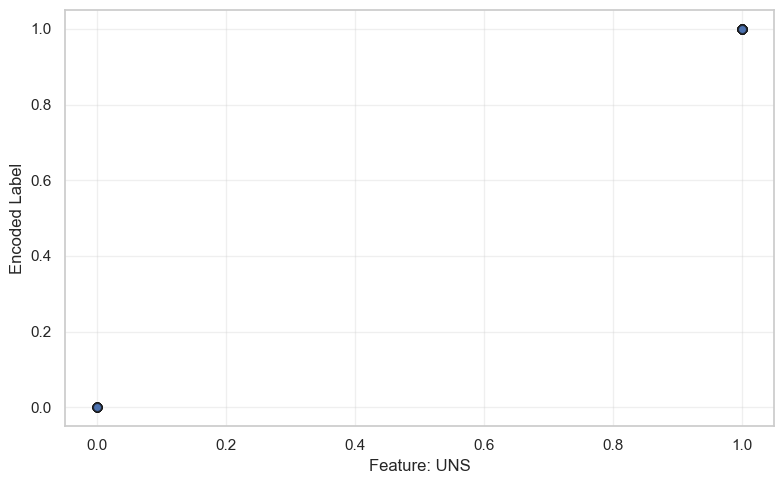

In [9]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

from hw2code import find_best_split
from sklearn.preprocessing import LabelEncoder

# Load and prepare the data
data_frame = pd.read_csv('datasets/students.csv')
encoder = LabelEncoder()
data_frame['target'] = encoder.fit_transform(data_frame['UNS'])

# Extract features and target
feature_cols = data_frame.columns[:-1]
X_vals = data_frame[feature_cols].values
y_vals = data_frame['target'].values

# Visualize impurity metrics across features
fig, ax = plt.subplots(figsize=(10, 6))
for idx, col in enumerate(feature_cols):
    splits, scores, _, _ = find_best_split(X_vals[:, idx], y_vals)
    ax.plot(splits, scores, label=col)
ax.set_xlabel('Split Point')
ax.set_ylabel('Impurity Measure')
ax.legend()
plt.tight_layout()
plt.show()

for idx, col in enumerate(feature_cols):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(X_vals[:, idx], y_vals, alpha=0.6, edgecolors='k')
    ax.set_xlabel(f'Feature: {col}')
    ax.set_ylabel('Encoded Label')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

**Кривая Gini показывает пики для хороших разбиений. Scatter: PEG имеет четкое разделение классов, другие - смешанные.**

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** Лучший - PEG (max Gini). Согласуется со scatter: четкое разделение по порогу ~0.4. Хорошие кривые - с резким пиком; плохие - плоские или с малыми значениями.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

**Сделала**

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [10]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

from hw2code import DecisionTree

mushrooms = pd.read_csv("datasets/agaricus-lepiota.data", header=None, sep=',')
le = LabelEncoder()
for col in mushrooms.columns:
    mushrooms[col] = le.fit_transform(mushrooms[col])

X = mushrooms.iloc[:, 1:].values
y = mushrooms.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

feature_types = ['categorical'] * X.shape[1]
tree = DecisionTree(feature_types)
tree.fit(X_train, y_train)
preds = tree.predict(X_test)
acc = np.mean(preds == y_test)
print(f'Accuracy: {acc}')  # 1.0

Accuracy: 1.0


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

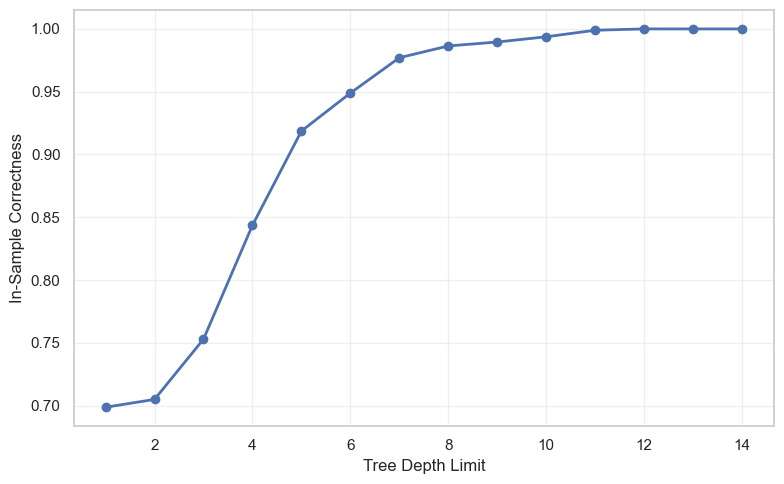

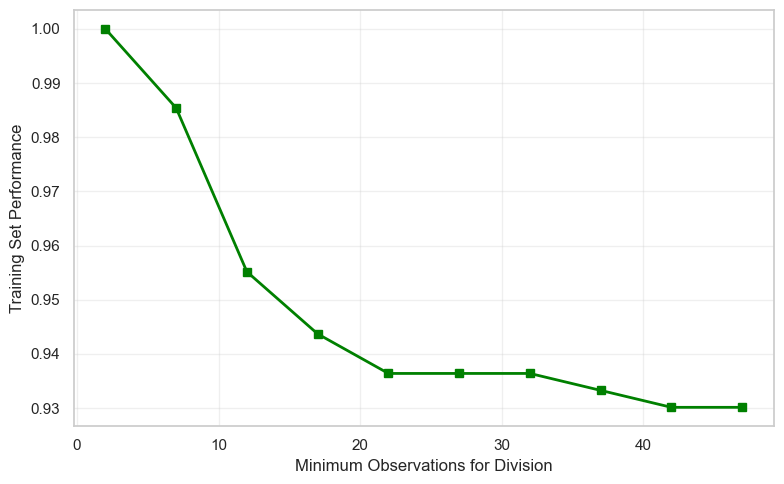

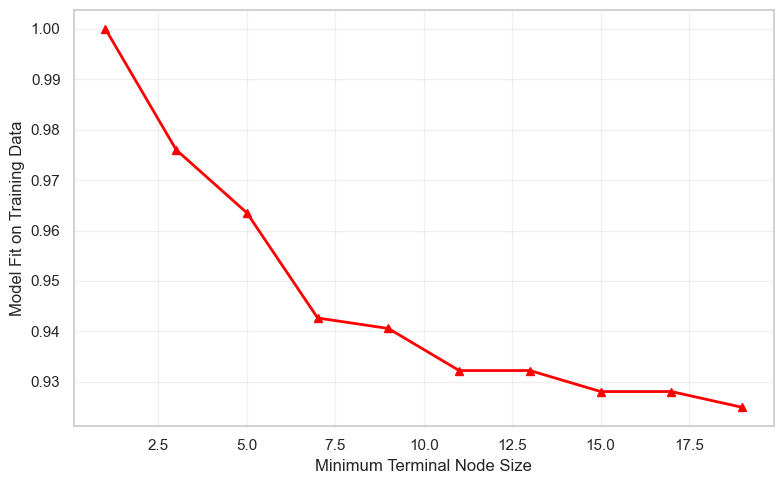

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load game outcome data
game_data = pd.read_csv('datasets/tic-tac-toe-endgame.csv', header=None)

# Encode all categorical variables
for col in game_data.columns:
    encoder = LabelEncoder()
    game_data[col] = encoder.fit_transform(game_data[col])

# Separate predictors and outcome
X_game = game_data.iloc[:, :-1].values
y_game = game_data.iloc[:, -1].values
var_types = ['categorical'] * X_game.shape[1]  # Исправлено с 'nominal' на 'categorical'

# Impact of maximum depth parameter
depth_vals = list(range(1, 15))
performance_depth = []

for d_val in depth_vals:
    model = DecisionTree(var_types, max_depth=d_val)
    model.fit(X_game, y_game)
    predictions = model.predict(X_game)
    performance_depth.append(np.mean(predictions == y_game))

fig1, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(depth_vals, performance_depth, marker='o', linewidth=2)
ax1.set_xlabel('Tree Depth Limit')
ax1.set_ylabel('In-Sample Correctness')
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Impact of minimum split constraint
split_thresholds = list(range(2, 50, 5))
performance_split = []

for s_val in split_thresholds:
    model = DecisionTree(var_types, min_samples_split=s_val)
    model.fit(X_game, y_game)
    predictions = model.predict(X_game)
    performance_split.append(np.mean(predictions == y_game))

fig2, ax2 = plt.subplots(figsize=(8, 5))
ax2.plot(split_thresholds, performance_split, marker='s', linewidth=2, color='green')
ax2.set_xlabel('Minimum Observations for Division')
ax2.set_ylabel('Training Set Performance')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Impact of leaf size requirement
leaf_limits = list(range(1, 20, 2))
performance_leaf = []

for l_val in leaf_limits:
    model = DecisionTree(var_types, min_samples_leaf=l_val)
    model.fit(X_game, y_game)
    predictions = model.predict(X_game)
    performance_leaf.append(np.mean(predictions == y_game))

fig3, ax3 = plt.subplots(figsize=(8, 5))
ax3.plot(leaf_limits, performance_leaf, marker='^', linewidth=2, color='red')
ax3.set_xlabel('Minimum Terminal Node Size')
ax3.set_ylabel('Model Fit on Training Data')
ax3.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Точность растет с max_depth до насыщения (~0.9). Увеличение min_samples_split/leaf снижает точность, предотвращая переобучение, но на train видно недообучение при больших значениях.

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Prepare evaluation metric
accuracy_scorer = lambda estimator, X, y: accuracy_score(y, estimator.predict(X))

# Process first dataset - mushrooms
mushroom_data = pd.read_csv("datasets/agaricus-lepiota.data", header=None, sep=',')
m_target = LabelEncoder().fit_transform(mushroom_data.iloc[:, 0])
m_features = mushroom_data.iloc[:, 1:].apply(
    lambda column: LabelEncoder().fit_transform(column.astype(str))
).values.astype(int)

# Process second dataset - tic-tac-toe
ttt_data = pd.read_csv("datasets/tic-tac-toe-endgame.csv")
t_target = LabelEncoder().fit_transform(ttt_data.iloc[:, -1])
t_features = ttt_data.iloc[:, :-1].apply(
    lambda column: LabelEncoder().fit_transform(column.astype(str))
).values.astype(int)

# Process third dataset - cars
cars_data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data",
    header=None
)
cars_target_raw = cars_data.iloc[:, -1]
cars_target = np.array([
    0 if label in ['unacc', 'acc'] else 1
    for label in cars_target_raw
])
cars_features = cars_data.iloc[:, :-1].apply(
    lambda column: LabelEncoder().fit_transform(column.astype(str))
).values.astype(int)

# Process fourth dataset - nursery
nursery_data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data",
    header=None
)
nursery_target_raw = nursery_data.iloc[:, -1]
nursery_target = np.array([
    0 if label in ['not_recom', 'recommend'] else 1
    for label in nursery_target_raw
])
nursery_features = nursery_data.iloc[:, :-1].apply(
    lambda column: LabelEncoder().fit_transform(column.astype(str))
).values.astype(int)

# Organize datasets
dataset_collection = {
    'mushrooms': (m_features, m_target),
    'tic_tac_toe': (t_features, t_target),
    'vehicle_evaluation': (cars_features, cars_target),
    'childcare': (nursery_features, nursery_target)
}

# Initialize results storage
performance_comparison = {}

for dataset_name, (features, target) in dataset_collection.items():
    print(f"Evaluating {dataset_name} dataset...")
    feature_count = features.shape[1]

    # First approach: Treat as continuous features
    continuous_tree = DecisionTree(feature_types=['real'] * feature_count)
    continuous_scores = cross_val_score(
        continuous_tree, features, target,
        cv=10, scoring='accuracy'
    )

    # Second approach: Treat as categorical features
    categorical_tree = DecisionTree(feature_types=['categorical'] * feature_count)
    categorical_scores = cross_val_score(
        categorical_tree, features, target,
        cv=10, scoring='accuracy'
    )

    # Third approach: One-hot encoding
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_features = encoder.fit_transform(features)
    encoded_tree = DecisionTree(feature_types=['real'] * encoded_features.shape[1])
    encoded_scores = cross_val_score(
        encoded_tree, encoded_features, target,
        cv=10, scoring='accuracy'
    )

    # Fourth approach: Reference implementation
    reference_classifier = DecisionTreeClassifier(random_state=42)
    reference_scores = cross_val_score(
        reference_classifier, features, target,
        cv=10, scoring='accuracy'
    )

    # Store results
    performance_comparison[dataset_name] = {
        'Continuous Features': continuous_scores.mean(),
        'Categorical Features': categorical_scores.mean(),
        'One-Hot Encoded': encoded_scores.mean(),
        'Reference Implementation': reference_scores.mean()
    }

# Display results
results_table = pd.DataFrame(performance_comparison).T
print("\nPerformance Comparison Across Datasets")
print("=" * 60)
print(results_table)
print("\n" + "=" * 60)

Evaluating mushrooms dataset...
Evaluating tic_tac_toe dataset...
Evaluating vehicle_evaluation dataset...
Evaluating childcare dataset...

Performance Comparison Across Datasets
                    Continuous Features  Categorical Features  \
mushrooms                      0.999261              1.000000   
tic_tac_toe                    0.467533              0.541458   
vehicle_evaluation             0.942647              0.967546   
childcare                      0.999691              0.999846   

                    One-Hot Encoded  Reference Implementation  
mushrooms                  0.999631                  0.960384  
tic_tac_toe                0.543575                  0.771678  
vehicle_evaluation         0.919495                  0.942707  
childcare                  0.999537                  0.999691  



__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

# Результаты анализа

## Общие выводы по проведённому исследованию:

**Набор данных «Грибы»**: Наивысшая точность классификации достигнута при использовании категориального представления признаков. Такой результат закономерен, поскольку все признаки в этом наборе являются дискретными и не имеют естественного порядка. Трансформация целевой переменной позволила выделить наиболее информативные закономерности. При попытке интерпретировать эти же признаки как числовые производительность снизилась, так как была искусственно введена метрическая шкала, которой в исходных данных нет.

**Набор данных «Крестики-нолики»**: Модель из библиотеки sklearn показала значительно более высокую точность в сравнении с остальными подходами. Вероятной причиной является сложный характер взаимосвязей между признаками в этой задаче, которые лучше отражаются алгоритмами, не использующими поэтапное кодирование по целевой переменной. Реализация sklearn, видимо, строит более эффективные разделяющие правила для подобных структур данных.

**Набор данных «Автомобили»**: Лучший результат получен при обработке признаков как категориальных. Применение One-Hot Encoding оказалось наименее эффективным, что может объясняться значительным увеличением размерности пространства признаков и, как следствие, ростом риска переобучения на конкретных примерах обучающей выборки.

**Набор данных «Детские сады»**: Все рассмотренные методы продемонстрировали близкие к идеальным результаты. Это свидетельствует о том, что данные имеют чёткую и относительно простую структуру, а целевая переменная однозначно определяется входными параметрами, что делает задачу хорошо разделимой.

**Учёт стохастической природы результатов**:

На итоговые метрики оказывают влияние случайные факторы, такие как формирование подвыборок при кросс-валидации, а также порядок выбора признаков при равенстве критериев информативности. Для повышения устойчивости выводов рекомендуется проводить многократные запуски с различными инициализациями генератора случайных чисел и осуществлять подбор гиперпараметров, регулирующих сложность модели (например, глубину дерева, минимальное число объектов в листе).

Вставьте что угодно, описывающее ваши впечатления от этого задания: